# Averaging Function Testing
## Imorting relevant directories

In [1]:
from pathlib import Path
import sys
sys.path.append('../')
from pma_open import *


## Naming relevant paths


In [2]:
file_path = '../pma files/hel1.pma'

## Average Frame Array function (avg_frame_arr)

In [3]:
#Testing avg_frame_arr function
avg_frame_data = avg_frame_arr(file_path)

Image Size: 512 x 512
Sucessfully generated average frame


In [4]:
print(f"Average Frame Data- shape: {avg_frame_data.shape}")
print(f"Average Frame Data- Type: {type(avg_frame_data)}")
print(f"Average Frame Data- dType: {avg_frame_data.dtype}")
# print(f"First line of Average Frame Data: {avg_frame_data[0]}")

Average Frame Data- shape: (512, 512)
Average Frame Data- Type: <class 'numpy.ndarray'>
Average Frame Data- dType: uint8


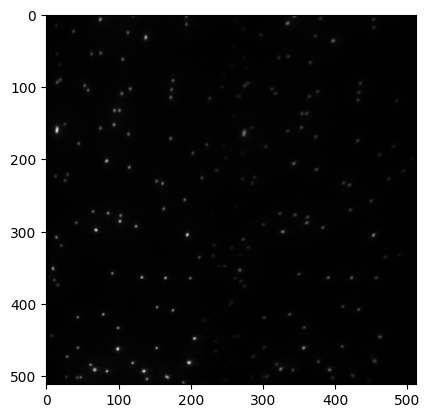

In [5]:
#Display Average frame using matplotlib
image = plt.imshow(avg_frame_data, cmap="grey");

## Average Frame png function (avg_frame_png)

In [6]:
#Testing avg_frame_png function
avg_frame_png(file_path)

Image Size: 512 x 512
Image Size: 512 x 512
Sucessfully generated average frame
Average frame saved as: hel1_Avg_Frame.png


<class 'numpy.ndarray'>
uint8
(512, 512)
7 213


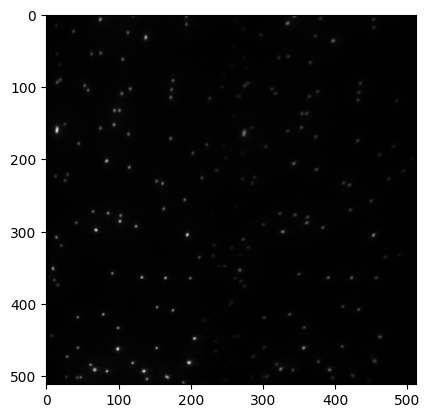

In [7]:
image_path = "hel1_Avg_Frame/hel1_Avg_Frame.png"
hel1_avg_image = io.imread(image_path)
print(type(hel1_avg_image))
print(hel1_avg_image.dtype)
print(hel1_avg_image.shape)
print(hel1_avg_image.min(), hel1_avg_image.max())

plt.imshow(hel1_avg_image, cmap="gray");

# Finding Peaks

## Scipy.ndimage maximum_filter
#### Assumes Gaussian PSF
#### Arguments: peak radius intensity threshold (scalar_percent)


In [8]:
# Function defined in pma_open.py file
# def find_peaks_scipy(image_path, peak_radius, scaler_percent):

#     image = io.imread(image_path, as_gray=True).astype(np.uint8)
#     sigma = peak_radius / 3.0
#     min_intensity = np.min(image)
#     max_intensity = np.max(image)
#     threshold = min_intensity + (scaler_percent / 100.0) * (max_intensity - min_intensity)
    
#     #Local max filter
#     local_max = maximum_filter(image, size=(3, 3)) == image  #3x3 neighborhood check
#     #Intensity threshold
#     peaks = (image >= threshold) & local_max
#     #Label peaks
#     labeled, num_features = label(peaks)
#     #Get peak coords
#     peak_coords = np.column_stack(np.where(labeled > 0))
    
#     return peak_coords


In [9]:
peaks_scipy = find_peaks_scipy(image_path, peak_radius=2, scaler_percent=20)
print(f"Number of peaks detected: {len(peaks_scipy)}")
print(f"First 10 peak coordinates:\n {peaks_scipy[:10]}")
print(f"Peaks data type: {peaks_scipy.dtype}")

Number of peaks detected: 137
First 10 peak coordinates:
 [[  1 120]
 [  2 344]
 [  3 194]
 [  7  75]
 [ 12 334]
 [ 14 194]
 [ 23  38]
 [ 25 113]
 [ 32 138]
 [ 37 397]]
Peaks data type: int64


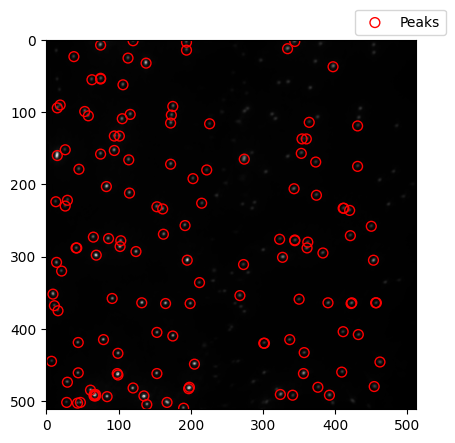

In [10]:
image = io.imread(image_path, as_gray=True)
plt.imshow(image, cmap="gray")
plt.scatter(peaks_scipy[:, 1], peaks_scipy[:, 0], s=50, facecolors='none', edgecolors='r', label='Peaks')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()

## skimage.feature.peak_local_max 

#### skimage.feature.peak_local_max(image, min_distance=1, threshold_abs=None, threshold_rel=None, exclude_border=True, num_peaks=inf, footprint=None, labels=None, num_peaks_per_label=inf, p_norm=inf)

Find peaks in an image as coordinate list.

Peaks are the local maxima in a region of 2 * min_distance + 1 (i.e. peaks are separated by at least min_distance).

If both threshold_abs and threshold_rel are provided, the maximum of the two is chosen as the minimum intensity threshold of peaks.

In [11]:
def find_peaks_scikit(image_path, peak_radius, scaler_percent):

    image = io.imread(image_path, as_gray=True).astype(np.uint8)
    sigma = peak_radius / 3.0
    min_intensity = np.min(image)
    max_intensity = np.max(image)
    threshold = min_intensity + (scaler_percent / 100.0) * (max_intensity - min_intensity)


    peak_coords = feature.peak_local_max(image, min_distance=int(sigma), threshold_abs=threshold)
    
    return peak_coords

In [12]:
peaks_scikit = find_peaks_scikit(image_path, peak_radius=2, scaler_percent=20)
print(f"Number of peaks detected: {len(peaks_scikit)}")
print(f"First 10 peak coordinates:\n {peaks_scikit[:10]}")
print(f"Peaks data type: {peaks_scikit.dtype}")

Number of peaks detected: 1298
First 10 peak coordinates:
 [[493 135]
 [464  99]
 [160  15]
 [305 195]
 [494 136]
 [161  15]
 [463 100]
 [464  98]
 [159  15]
 [483 197]]
Peaks data type: int64


/var/folders/r0/qp6_p2111v1dzb0fg2bbfqsr0000gn/T/ipykernel_10818/1854430259.py:10: RuntimeWarning: When min_distance < 1, peak_local_max acts as finding image > max(threshold_abs, threshold_rel * max(image)).
  peak_coords = feature.peak_local_max(image, min_distance=int(sigma), threshold_abs=threshold)


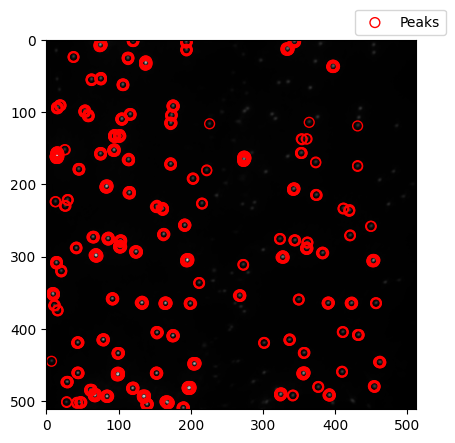

In [13]:
plt.imshow(image, cmap="gray")
plt.scatter(peaks_scikit[:, 1], peaks_scikit[:, 0], s=50, facecolors='none', edgecolors='r', label='Peaks')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()

It appears as though scikit (skimage) is worse at detecting peaks because it requirees we define a minimum distance between peaks. 
#This is not necessary with scipy's maximum_fiter.

Skimage often detechs multiple peaks in the same location, while scipy does not. This can be observed by the number of peaks detected by each method and also the thickness of some of the scatter points in the plot.

## We should proceed with our find_peaks_scipy funciton